In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from dask import optimize
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_8716/3290393657.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [2]:
import cftime

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [4]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'hus' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_hus_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_hus_his)

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/hus/gn/v20190514/


<xarray.Dataset>
Dimensions:    (time: 1980, plev: 19, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(60, 19, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            hus
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/dfa53149-c042-41e6-ae7c-3e2fa98f5f68...
    version_id:             v20190514

### The following works as an integral $TPW = 1/g \; \int_0^{z_{top}} q \; dp$

In [5]:
q = ds_hus_his.hus
plev = ds_hus_his.plev
plev_diff =  - plev.diff("plev")
delta_p = plev_diff.pad(plev=(0, 1), constant_values=0)
q_delta_p = q * delta_p
TPW = (q_delta_p.sum(dim="plev") / 9.81).rename("TPW")
TPW 

/Users/zimu/miniforge3/envs/pangeo_env/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'TPW' (time: 1980, lat: 192, lon: 288)>
dask.array<truediv, shape=(1980, 192, 288), dtype=float64, chunksize=(60, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [6]:
TPW = TPW * ds_area.areacella
TPW_timeseries = TPW.sum(dim = ["lat", "lon"])
TPW_timeseries

<xarray.DataArray (time: 1980)>
dask.array<sum-aggregate, shape=(1980,), dtype=float64, chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [7]:
TPW_timeseries = TPW_timeseries.chunk({'time': 1980})
TPW_timeseries = TPW_timeseries.persist()
TPW_timeseries

<xarray.DataArray (time: 1980)>
dask.array<rechunk-merge, shape=(1980,), dtype=float64, chunksize=(1980,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

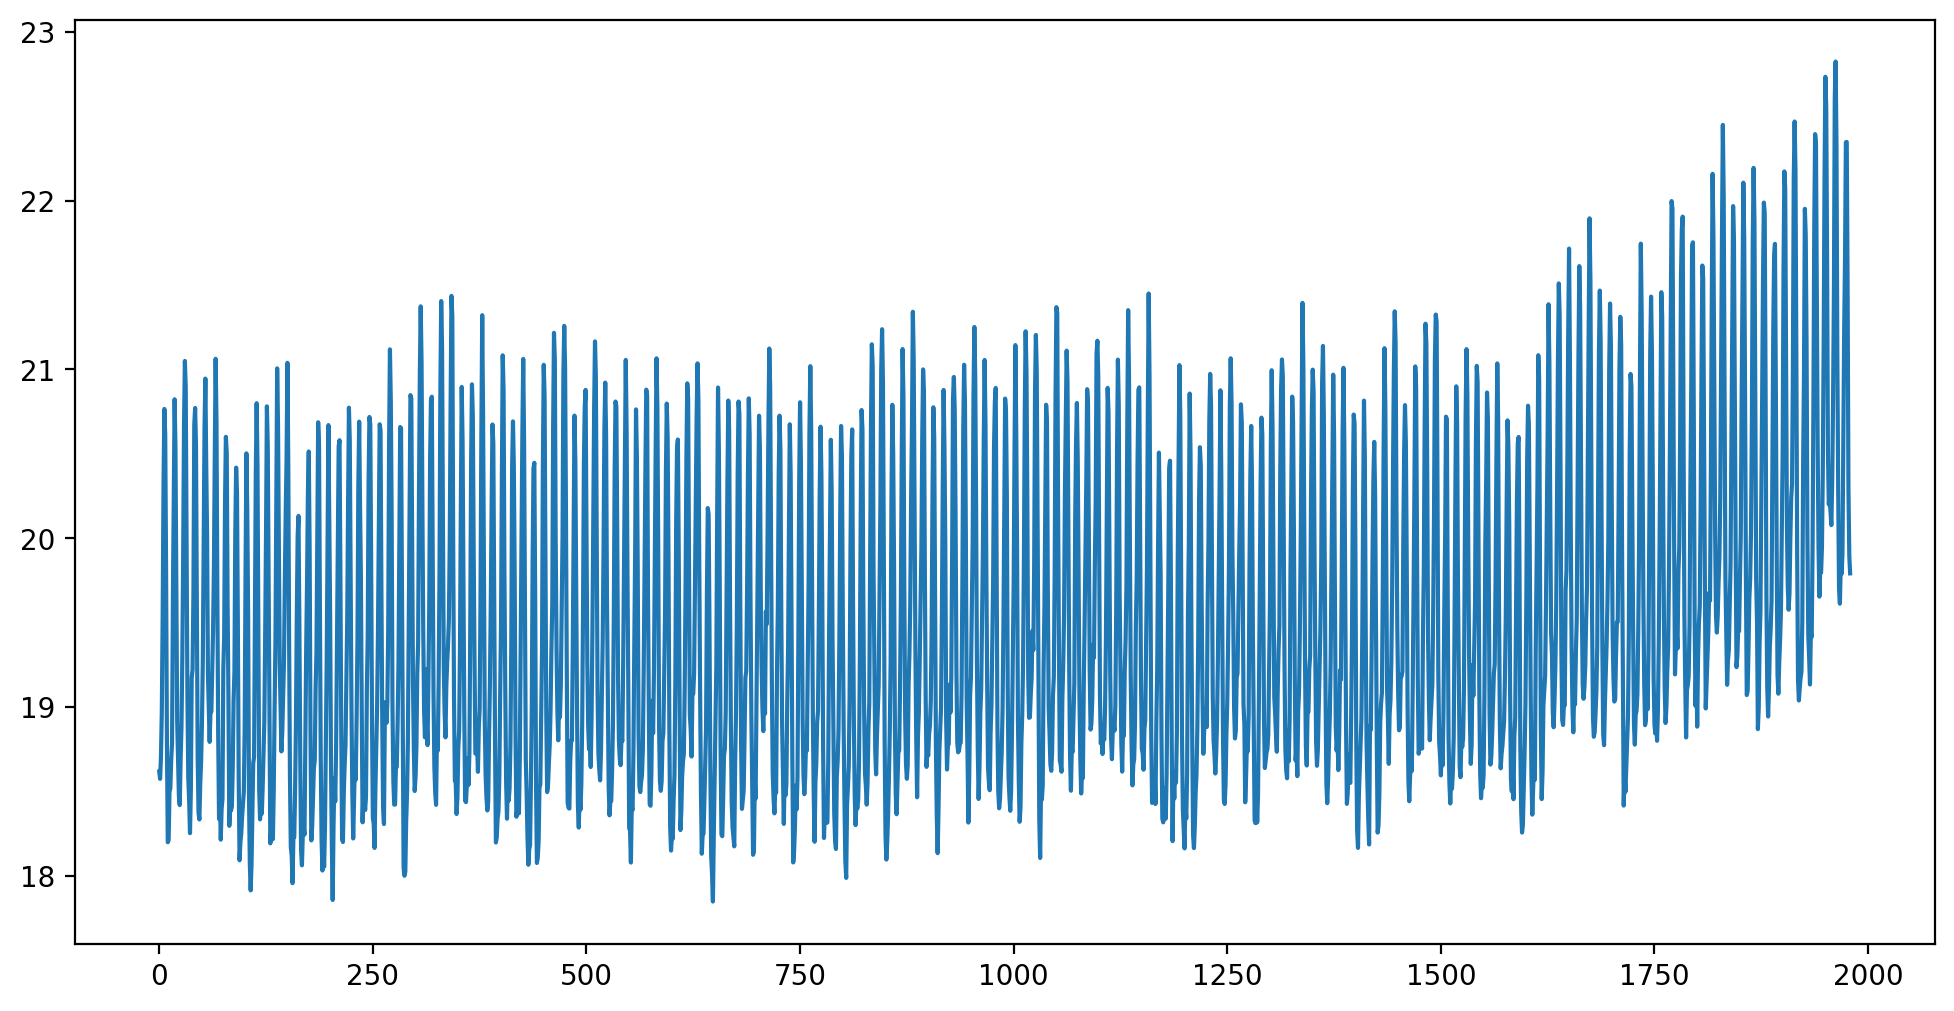

In [8]:
array_TPW_ts = np.array(TPW_timeseries) / float(total_area)
plt.plot(array_TPW_ts)
plt.show()

In [9]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_tas_his)

date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# weighted product
tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# convert to np array
array_tas_ts = np.array(tas_timeseries_his)
# plt.plot(array_tas_ts)
# plt.show()
year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# plt.plot(year_tas_ts)
# plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/a7278f6d-6a1b-4050-8f06-a8033604736a...
    version_id:             v20190514

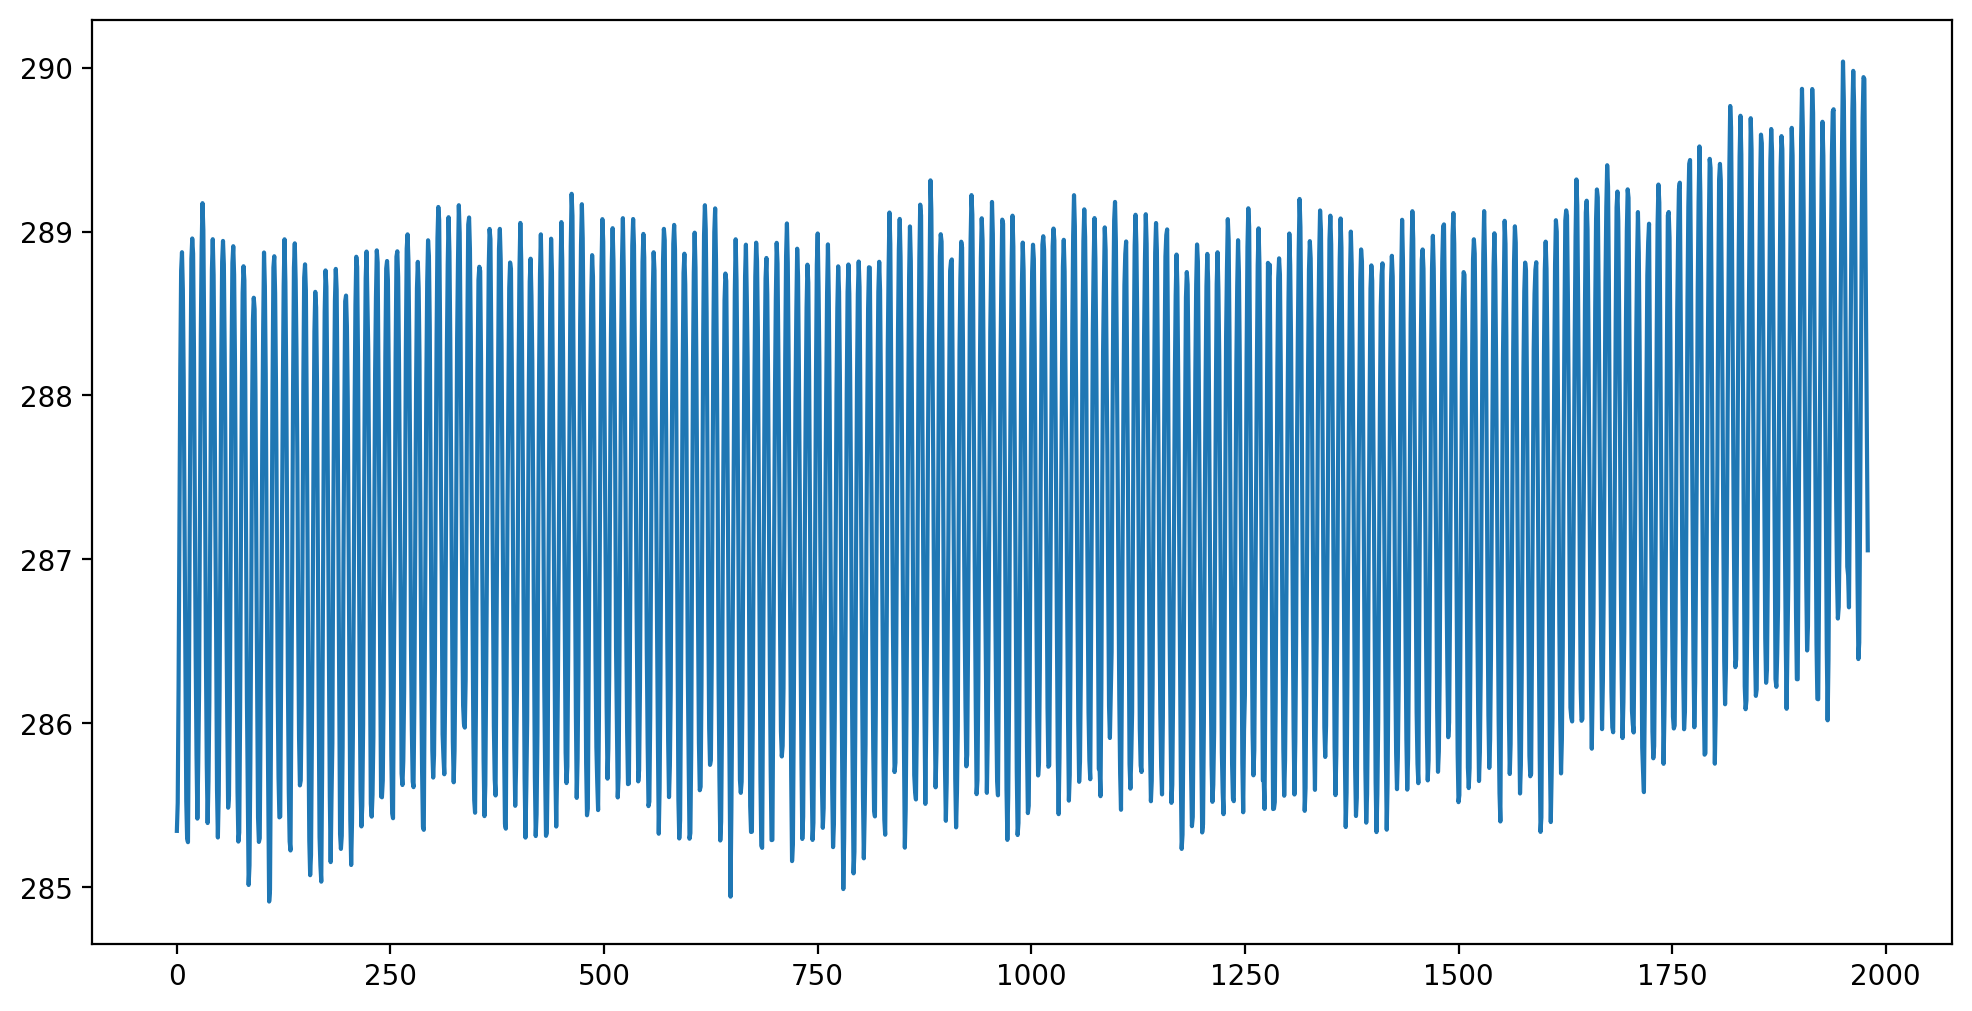

In [10]:
plt.plot(array_tas_ts)
plt.show()

### Want to estimate $TPW \propto \exp(\alpha + \beta * \Delta T)$. This is the simplified Calusius-Claperon formula in Marshall & Plumb

{'fit_intercept': True, 'normalize': 'deprecated', 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.03458014], dtype=float32), 'rank_': 1, 'singular_': array([57.28155], dtype=float32), 'intercept_': -6.966396}
alpha: 0.0009430456557311118
beta: 0.03458014130592346


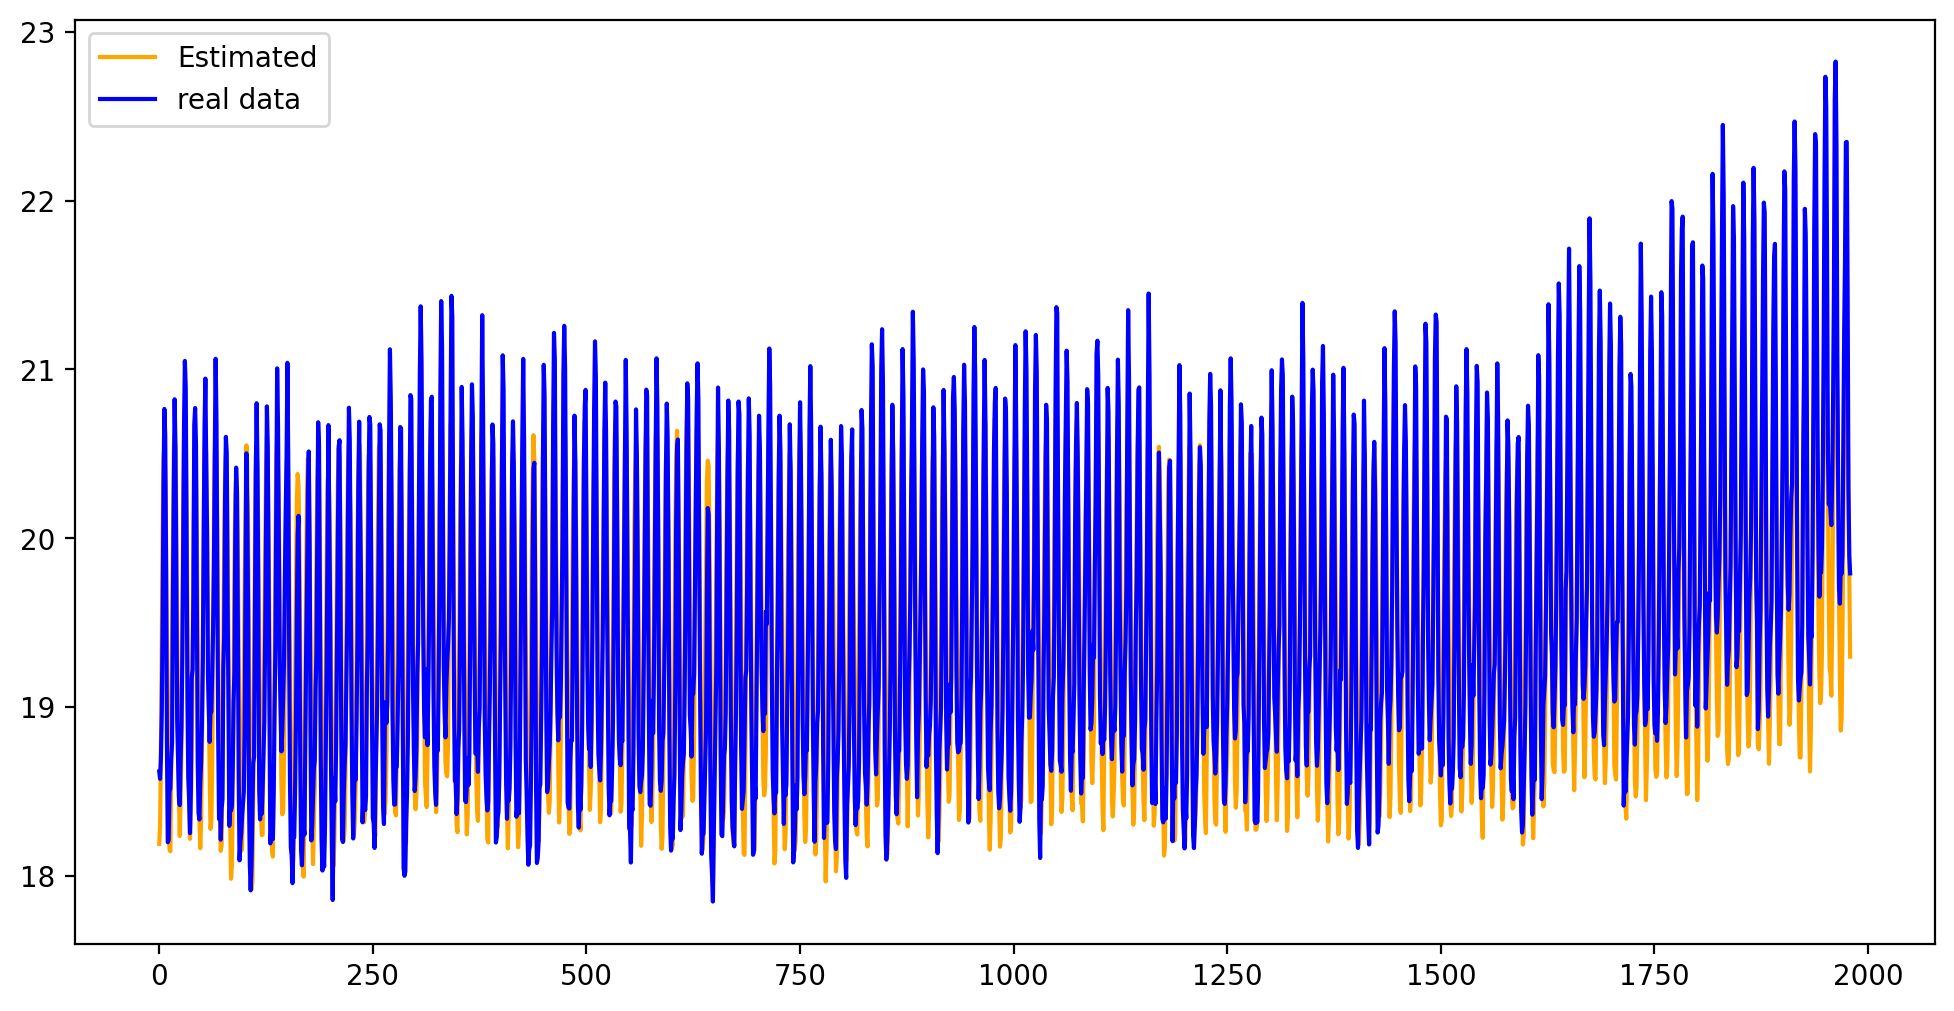

In [13]:
ln_TPW = np.log(array_TPW_ts)
X_tas_ts = array_tas_ts.reshape(-1, 1)

LR_model = LinearRegression()
LR_model.fit(X_tas_ts, ln_TPW)

print(vars(LR_model))

beta = LR_model.coef_[0]  # Slope is negative feedback parameter
alpha = LR_model.intercept_  # Intercept is radiative forcing

print(f"alpha: {np.exp(alpha)}")
print(f"beta: {beta}")

estimated_TPW_ts = np.exp(alpha + beta * array_tas_ts)
plt.plot(estimated_TPW_ts, label="Estimated", color="orange")
plt.plot(array_TPW_ts, label="real data", color="blue")
plt.legend()
plt.show()

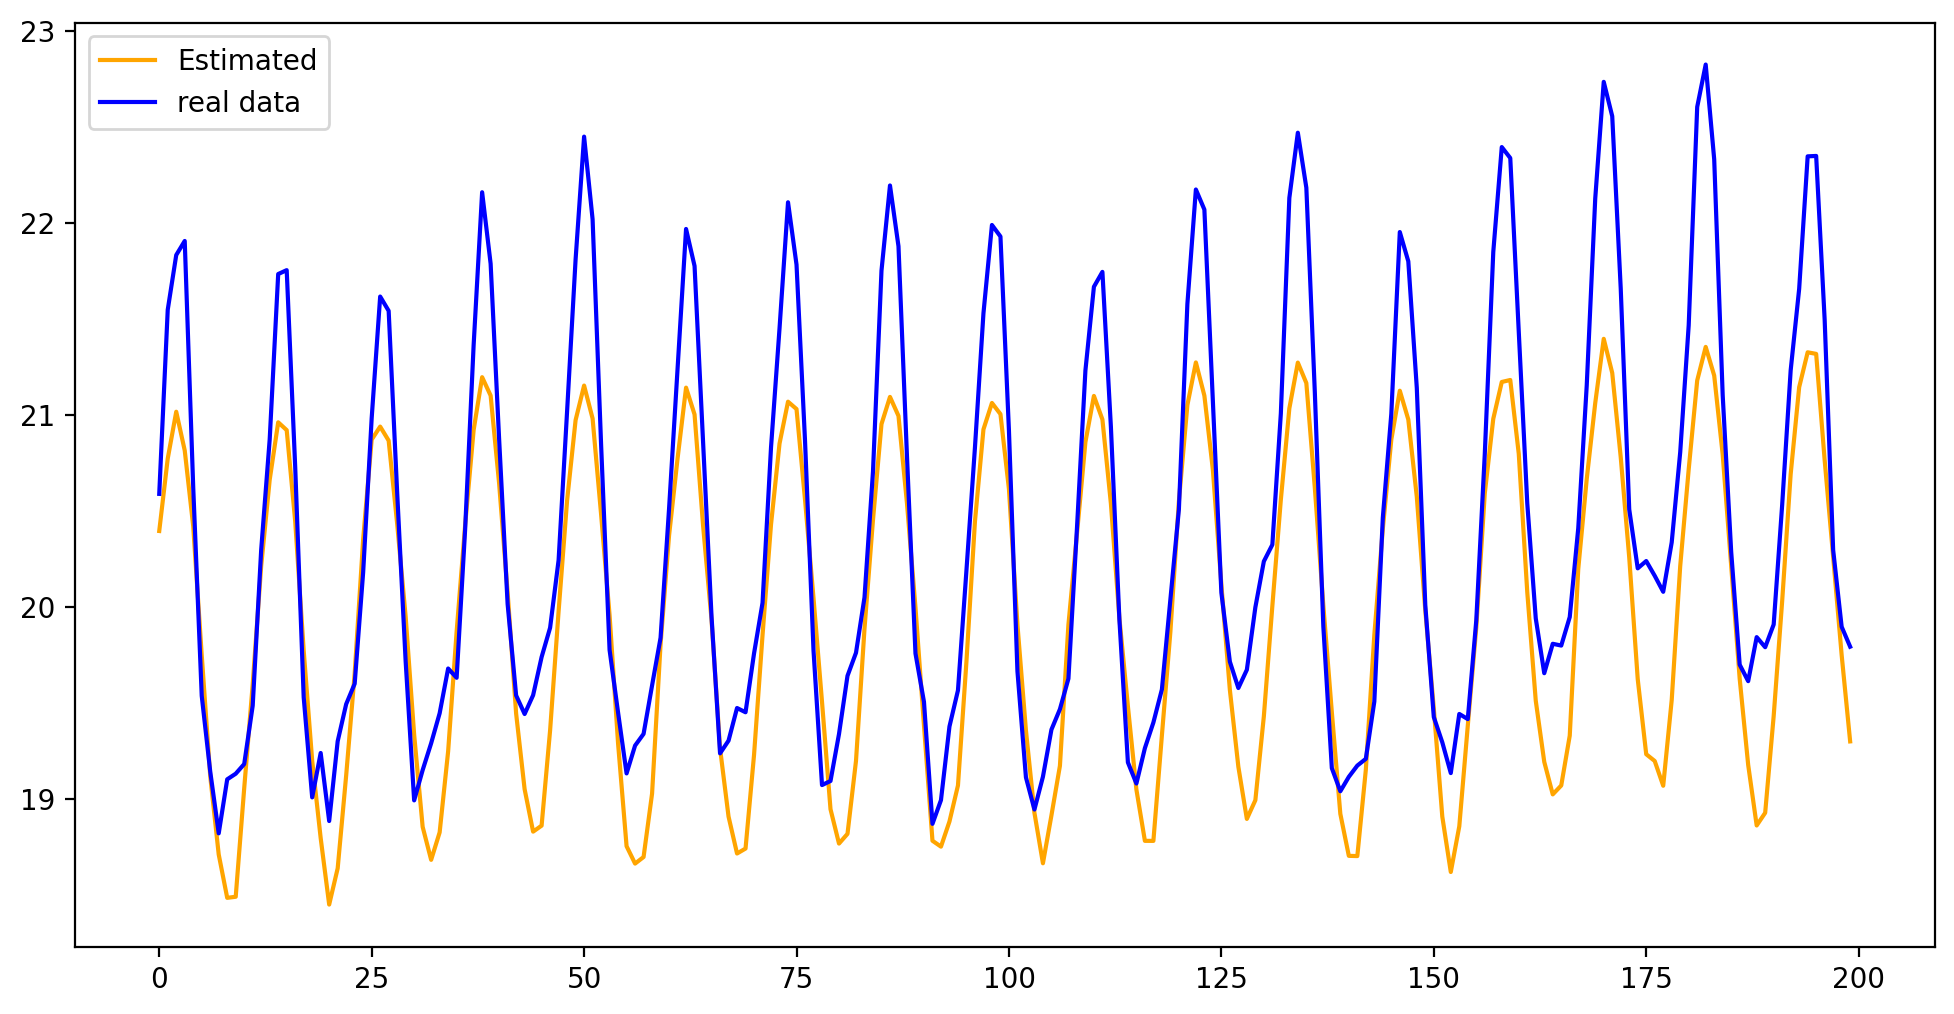

In [12]:
estimated_TPW_ts = np.exp(alpha + beta * array_tas_ts)
plt.plot(estimated_TPW_ts[-200:], label="Estimated", color="orange")
plt.plot(array_TPW_ts[-200:], label="real data", color="blue")
plt.legend()
plt.show()

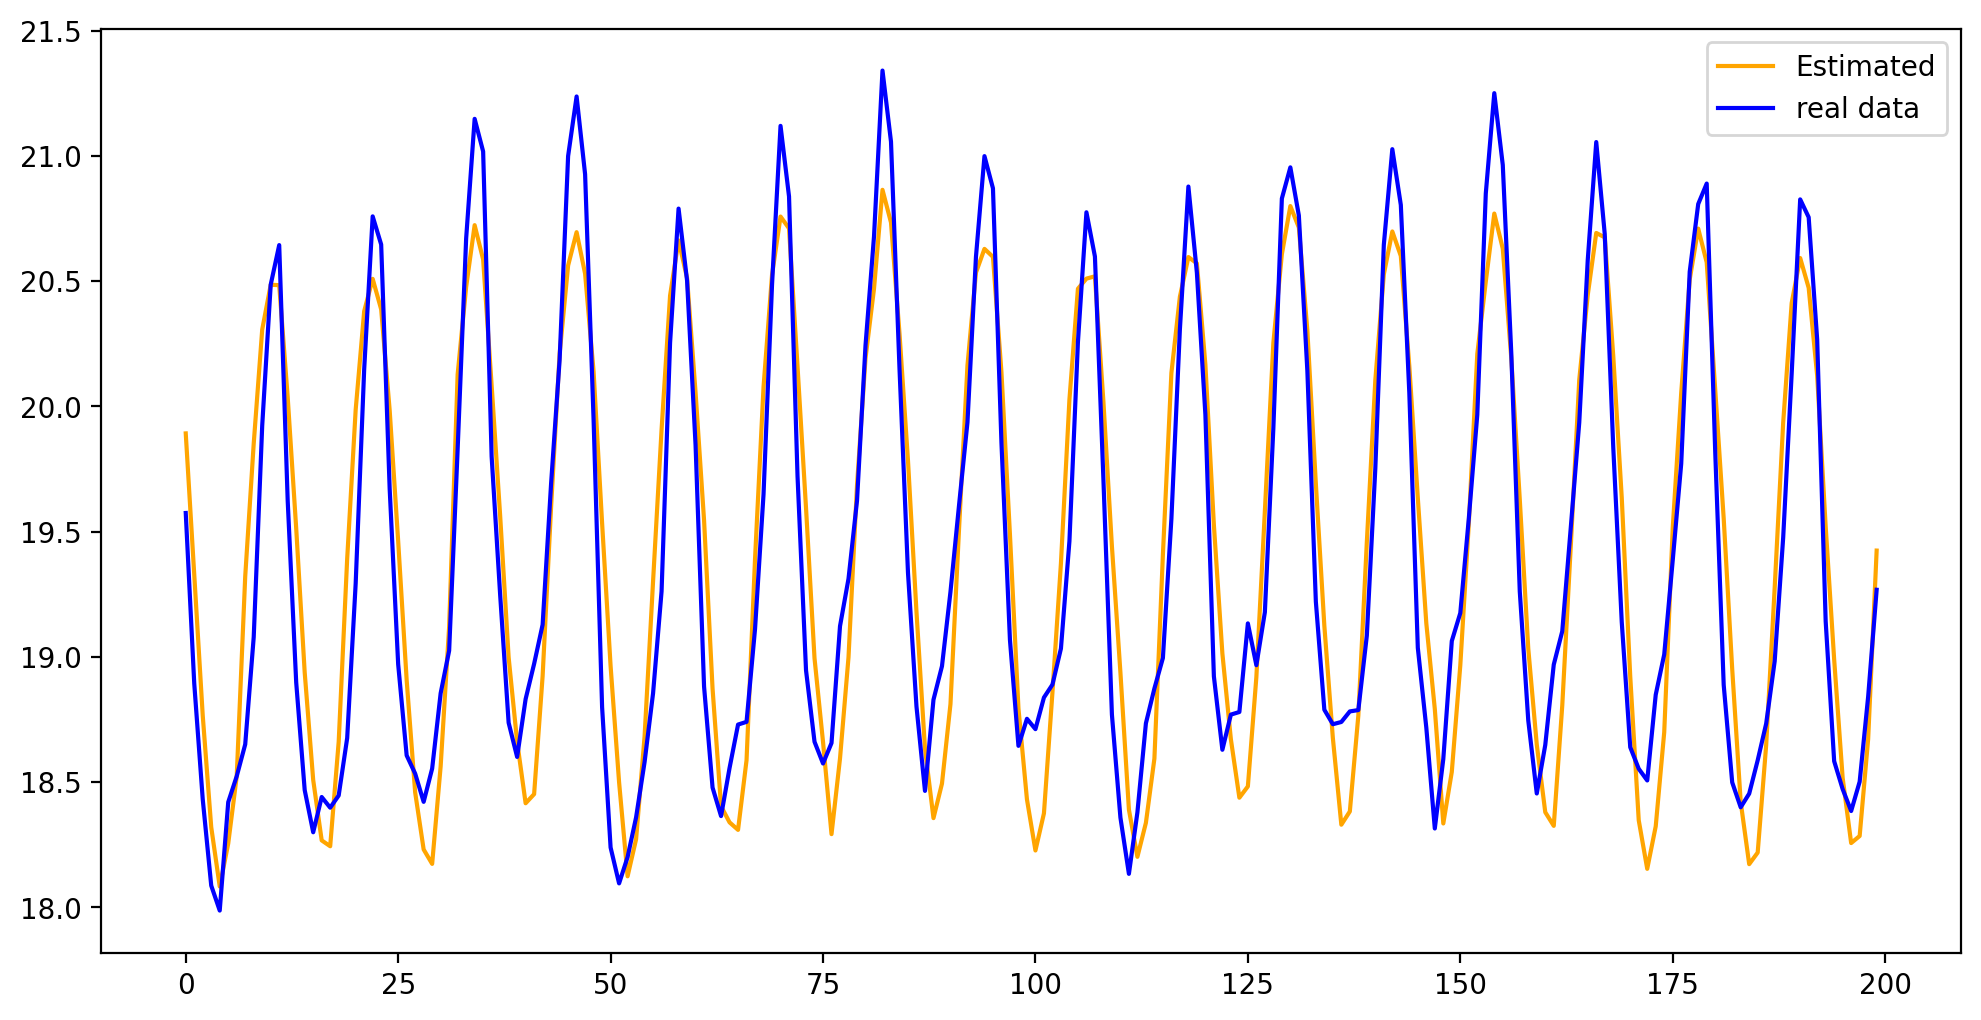

In [14]:
estimated_TPW_ts = np.exp(alpha + beta * array_tas_ts)
plt.plot(estimated_TPW_ts[800:1000], label="Estimated", color="orange")
plt.plot(array_TPW_ts[800:1000], label="real data", color="blue")
plt.legend()
plt.show()